Lo primo es cargar las librerias necesarias para realizar el proyecto

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

#### Preprocesamiento de datos


El conjunto de datos tambien conocido como dataset a utilizar son los datos del MNIST

Sobre los datos:

Los datos MNIST son un conjunto de datos ampliamente utilizado en el campo del aprendizaje automático y la visión por computadora. MNIST es un acrónimo de "Modified National Institute of Standards and Technology" y se refiere a una base de datos que contiene imágenes de dígitos escritos a mano.

Caracteristicas:

Imágenes: La base de datos MNIST contiene un conjunto de 70,000 imágenes en blanco y negro (escala de grises) de dígitos escritos a mano. Estas imágenes son de 28x28 píxeles y muestran dígitos del 0 al 9.

Etiquetas: Cada imagen en el conjunto de datos está etiquetada con el dígito que representa. Esto significa que cada imagen tiene una etiqueta que indica si es un 0, 1, 2, ..., 9.

Se descargan y cargan los datos en memoria para poder usarse, haciendo uso de un modulo que ofrece pytorch para descargar diferentes tipos de datasets

In [6]:
# Los imagenes del dataset de MNIST se convertiran a tensores de 4 dimensiones
# (image, alto, ancho y color)
transform = v2.ToTensor()

# Descarga de los datos de MNIST

# Datos de entrenamiento
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Datos de prueba
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)


Visualizacion de una muestra aleatoria de los datos de entrenamiento, esto se realiza utilizando la libreria matplotlib

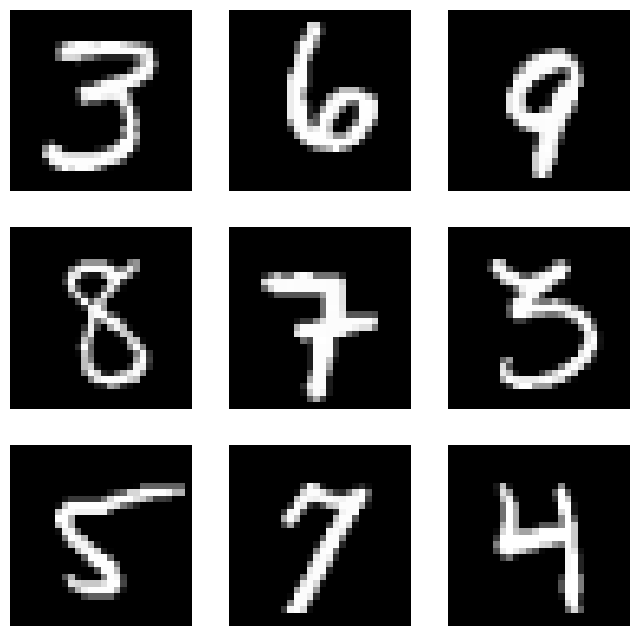

In [7]:
# Se define la figura
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # se genera un numero aleatorio
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    # Se selecciona la imagen correspondiente al indice
    # aleatoria generado
    img, label = train_data[sample_idx]
    # Se grafica la imagen
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Con el conjunto de datos ya cargados se usa la clase "DataLoader" para lo siguiente: 
* Creacion de lotes (division de los datos en pequenos conjuntos) esto permite realizar actualizaciones de los parámetros del modelo más frecuentemente para acelerar la convergencia del modelo, tambien los lotes pueden cargarse y preprocesarse en paralelo, lo que es util cuando se usan mutiples nucleos de la CPU ademas los lotes permite la mezcla de los ejemplos en cada epoch de entrenamiento.
*  Mezclar aleatoriamente los datos en cada epotch del entrenamiento, para evitar que el modelo aprenda patrones espurios
* Hacer el conjunto de datos iterable (que una sentecia como un for puede recorrer los datos)

In [26]:
# Crear lote de datos
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

Preprocesamiento de nuevos datos

Para el procesamiento de nuevos datos que son externos al dataset provisto por pytorch, se tienen que realizar un proceso
ligeramente diferente. Ya que se tiene que estandarizar los datos a ingresar a las mismas caracteristicas que tiene los datos con los que se entreno el modelo, estas son:
* Imagen de un solo canal (canal de grises)
* Tamano de 28x28 pixeles
* Fonda negro, y el digito escrito en color blanco

Primero se crea un nuevo tranformador con las siguientes funcionalidades: 
* Cambiar el tamano de la imagen ingresada (si fuese de mayor resolucion) al tamano de la imagen con la que fue entrenado el modelo 28x28 
* Escalar la imagen a solo canal (canal de grises)
* Invertir el color ya que las imagenes con las que se entreno el modelo tienen el fondo negro y el simbolo en blaco
* Convertir la imagen en un Tensor, que es el tipo de dato que manejan las funciones de pytorch

In [9]:
transform_ = v2.Compose([
    v2.Resize((28, 28)),
    v2.Grayscale(),
    v2.RandomInvert(1.0),
    v2.ToTensor()
])

El formato de canales de imagen que por lo general se maneja es RGBA (Red, Green, Blue, Alpha) donde el Alpha controla la transparencia y la escala de grises, esto es algo a considerar mas adelante.

Se carga una imagen para probar, esta tiene las siguientes dimensiones; 200x200 pixeles y 4 canales de color (RGBA), esta imagen viene en un archivo .txt el cual contiene un arreglo de una dimension con los datos de todos los pixeles de la imagen, por lo que primero se lee con una funcion del modulo numpy y despues se redimensiona a un formato de 200x200 pixeles y 4 canales:

In [12]:
# Cargar arreglo (imagen)
X = np.loadtxt("./data/IMG/img.txt", dtype=int)
X.shape

(160000,)

In [13]:
# Redimensionar de (1) a (200x200x4)
X = X.reshape(200, 200, 4)
X.shape

(200, 200, 4)

Ya que la imagen cargada tiene fondo transparente y puede haber problemas al pasarla por el transformador, se cambia a un fondo blanco:

In [16]:
# Cambiar fonda a blanco
X[X[:,:, 3] == 0] = [255,255,255,255]
# Comvertir array a formato PILImage para un mejor manejo en el transformador
X = Image.fromarray(X.astype(np.uint8))

En este punto ya se a transformado el arreglo de 1 dimension a una imagen de 200x200 pixeles y 4 canales, pero si se intentara pasar al modelo marcaria una excepcion ya que la imagen no es de las caracteristicas con las que se entreno la red neuronal del modelo (4, 28, 28) 

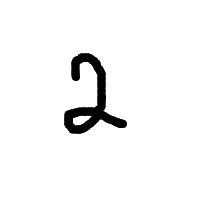

In [17]:
X

Aplicacion del transformador a la imagen:

In [18]:
X = transform_(X)
X.shape

torch.Size([1, 28, 28])

Vizualizacion de la imagen ya estandarizada lista para ser ingresada al modelo:

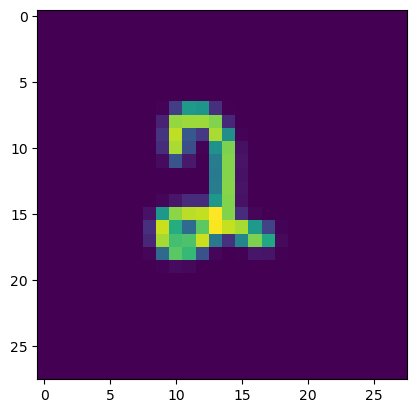

In [19]:
plt.imshow(np.transpose(X.numpy(), (1, 2, 0)))
plt.show()

Tambien se puede cargar directamente una imagen

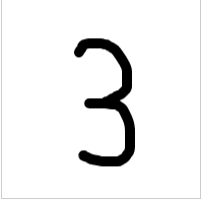

In [37]:
img = Image.open("./data/IMG/Three.png")
img

Y Realizar la transformacion directamente, no es necesario hacer los pasos que se realizaron con el arreglo

In [38]:
img = transform_(img)
img.shape

torch.Size([1, 28, 28])

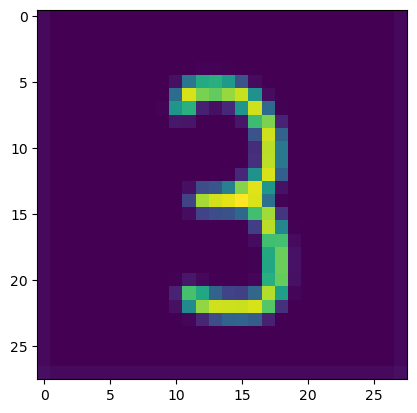

In [48]:
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.show()

#### Creacion de la clase del modelo

Creamos un modelo de una Red neuronal convolucional (CNN)

In [20]:
# Creacion de la clase que hereda de la clase Module de pytorch, Clase base para todos los módulos de red neuronales
class CNNModel(nn.Module):
    # Definicion del constructor de la clase
    def __init__(self):
        # Inicializacion del constructor de la clase padre (Module)
        super().__init__()
        # Instacia de la primera capa convolucional
        # Recibe una imegen, regrea 6 filtros, el tamano
        # del kernel de 3x3 y con paso 1
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        # Instancia de la segunda capa  convolucional
        # Recibe 6 filtros, regresa 16 filtros, el tamano
        # del kernel es de 3x3 con paso 1
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        
        # Capas de red neuronal normal
        # Capa de entrada con 120 neuronas
        self.fc1 = nn.Linear(5*5*16, 120)
        # Capa que conecta la capa anterior con 84 neuronas
        self.fc2 = nn.Linear(120, 84)
        # Capa de salida que conecta la capa anterior con
        # 10 neuronas que representan las 10 categorias de
        # los datos
        self.fc3 = nn.Linear(84, 10)

    # En esta funcion se especifica como van a pasar los  datos
    # atravez de la CNN 
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2) 

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)  

        X = X.view(-1, 16*5*5)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

Una vez definido el modelo, se instancia no sin antes crear una semilla de aletoriedad para que no varien los datos si se quiere replicar

In [21]:
# Creando semilla
torch.manual_seed(41)
# Instacia del modelo
model = CNNModel()
model

CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

#### Entrenamiento del modelo

Configuracion de la funcion de perdida y el optimzador

In [22]:
# Creacion de la funcion de perdida
criterion = nn.CrossEntropyLoss()
# Creacion del optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Entrenamiento del modelo 

In [29]:
%time

# Creacion de la variables:
# Se define cuantos epochs se van a realizar
# Un epoch es toda una interacion de todos los
# datos atravez de la red neuronal
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Bucle que se ejecuta las veces indicadas (epochs)
for i in range(epochs):
    trn_corr = tst_corr = 0
    # Se itera el conjunto de datos de entrenamiento,
    # se obtiene:
    # X_train = lote de imagenes
    # y_train = lote de etiquetas de las 10 imagenes
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
       # Se ingresa el lote de imagenes al modelo
       # Arroja la prediccion y_pred 
        y_pred = model(X_train)
        # se calcula la perdida con la funcion
        # comparando la prediccion contra los datos reales
        loss  = criterion(y_pred, y_train)
        # Se obtiene el valor mas grande, este es
        # el que cree la red que es mas acertado 
        predicted = torch.max(y_pred.data, 1)[1]
        # Se verifica que sean correctas la predicciones
        # contra los valores reales
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Depurar los datos del entrenamiento por consola
        if b%600 == 0:
            print(f"Epoch: {i} Batch: {b} Loss: {loss.item()}")
    
    train_losses.append(loss)
    train_correct.append(trn_corr)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
Epoch: 0 Batch: 600 Loss: 0.17990995943546295
Epoch: 0 Batch: 1200 Loss: 0.2365473210811615
Epoch: 0 Batch: 1800 Loss: 0.017028750851750374
Epoch: 0 Batch: 2400 Loss: 0.0963820293545723
Epoch: 0 Batch: 3000 Loss: 0.07535302639007568
Epoch: 0 Batch: 3600 Loss: 0.01270303875207901
Epoch: 0 Batch: 4200 Loss: 0.01720208115875721
Epoch: 0 Batch: 4800 Loss: 0.04618168622255325
Epoch: 0 Batch: 5400 Loss: 0.039895858615636826
Epoch: 0 Batch: 6000 Loss: 0.005244140513241291
Epoch: 1 Batch: 600 Loss: 0.012408566661179066
Epoch: 1 Batch: 1200 Loss: 0.017605304718017578
Epoch: 1 Batch: 1800 Loss: 0.056576281785964966
Epoch: 1 Batch: 2400 Loss: 0.1947897970676422
Epoch: 1 Batch: 3000 Loss: 0.0024670411366969347
Epoch: 1 Batch: 3600 Loss: 0.055994220077991486
Epoch: 1 Batch: 4200 Loss: 0.0019240766996517777
Epoch: 1 Batch: 4800 Loss: 0.0003076336288359016
Epoch: 1 Batch: 5400 Loss: 0.0005665621138177812
Epoch: 1 Batch: 6000 Loss: 0.0026

#### Prueba del modelo con los datos de entrenamiento

Prueba con un solo lote 

Se muestra por pantalla las imagenes, de un solo lote

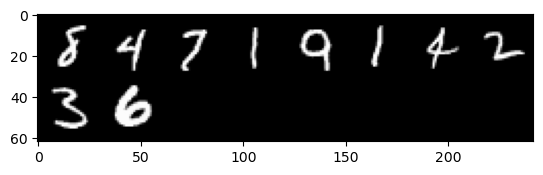

In [27]:
# Se itera el conjunto de prueba
dataiter = iter(test_loader)
# Se obtiene las imagenes y etiquetas
imgs, labels = next(dataiter)
# Se muestran las imagenes graficamente
plt.imshow(np.transpose(make_grid(imgs).numpy(), (1, 2, 0)))
plt.show()

Etiquetas de las imagenes

In [28]:
print(labels)

tensor([8, 4, 7, 1, 9, 1, 4, 2, 3, 6])


Se ingresan las imagenes al modelo

In [49]:
outputs = model(imgs)

Puntuaciones de cada caterogoria

In [56]:
outputs.data

tensor([[-9.5369e+00, -1.8017e+01, -1.9068e+01, -1.1731e+01, -1.2774e+01,
         -1.3291e-03, -1.1593e+01, -7.3267e+00, -8.3569e+00, -7.9767e+00],
        [-1.1831e+01, -1.6621e+01, -1.6933e+01, -2.0323e+01, -1.1809e+01,
         -8.3936e+00, -2.4185e-04, -2.1780e+01, -1.4289e+01, -1.7005e+01],
        [-2.3443e+01, -1.7024e+01, -1.3549e+01, -1.9669e-05, -2.0952e+01,
         -1.0995e+01, -1.9592e+01, -1.8252e+01, -1.3463e+01, -1.6808e+01],
        [-2.6095e+01, -2.4720e+01, -2.6713e+01, -3.5567e+01, -1.8520e+01,
         -1.7440e+01,  0.0000e+00, -3.6313e+01, -1.7701e+01, -3.6159e+01],
        [-1.5328e+01, -1.6136e+01, -1.4221e+01, -2.2071e+01, -1.2258e+01,
         -1.3752e+01, -6.7949e-06, -2.5960e+01, -1.7496e+01, -2.5281e+01],
        [-2.1141e+01, -2.0995e+01, -1.6499e+01, -1.6153e+01, -1.1309e+01,
         -1.8750e+01, -2.9262e+01, -9.7571e+00, -1.7486e+01, -7.0450e-05],
        [-1.5961e-04, -1.4591e+01, -9.2510e+00, -1.3390e+01, -1.3880e+01,
         -1.5010e+01, -1.3523e+0

Se obtiene los valores mas altos, estos son por los que mas se inclino la red neuronal

In [31]:
predicted = torch.max(outputs, 1)[1]

Predicciones

In [32]:
predicted

tensor([8, 4, 7, 1, 9, 1, 4, 2, 3, 6])

Prueba del modelo con todo los datos de entrenamiento

In [33]:
#Definicion de variables
correct = total = 0
# Se desactiva la propagacion hacia atras
with torch.no_grad():
    # se itera el conjunto de entrenamiento
    for data in test_loader:
        # Se obtiene las imagenes y las etiquetas
        imgs, labels = data
        # Se ingresan las imagenes al modelo
        outputs = model(imgs)
        # Se obtiene las prediccion de la red neuronal
        predicted = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        # Se cuentan las imagenes hacertadas
        correct += (predicted == labels).sum().item()

print(f'Presicion de la red en las 10,000 imagenes de prueba: {100 * correct // total} %')

Presicion de la red en las 10,000 imagenes de prueba: 98 %


Prueba del modelo con las imagenes que no pertenecen al dataset

In [46]:
# Imagen del arreglo que contiene el numero 2
with torch.no_grad():
    y = model(X)
torch.max(y.data, 1)[1]

tensor([2])

In [47]:
# Imagen png que contiene el numero 3
with torch.no_grad():
    y = model(img)
torch.max(y.data, 1)[1]

tensor([3])

Se guardan los parametros del modelo para luego ser cargados posteriormente cuando se vaya a utilizar mas adelante y asi no tener que entrenar nuevamente el modelo

In [ ]:
# Guardando modelo
torch.save(model.state_dict(), "CNNModel.pth")

In [57]:
# Cargando parametros al modelo
model = CNNModel()
model.load_state_dict(torch.load("CNNModel.pth"))

<All keys matched successfully>